# Overview
These models aim to predict the distribution of Covid variants B.1.1.7, B.1.135, P.1 in the future primarily from vaccination data from the previous weeks.

Input shape: (# sequences, 21 time steps, 54 features)

Features are:
*   One-hot encoded state
*   Vaccinations per 100 to date
*   Proportion of B.1.1.7 cases, B.1.135 cases, P.1 cases

Output shape per model: (# sequences, 1 feature)
*   Proportion of B.1.1.7 cases / B.1.135 cases / P.1 cases 2 weeks after input data

The proportion of variant x is estimated by the sum of variant x cases over the last 10 days divided by the total number of variant cases over the last 10 days.

# Preprocessing

In [ ]:
value = [
    ('AK', 'Alaska'),
    ('AL', 'Alabama'),
    ('AZ', 'Arizona'),
    ('AR', 'Arkansas'),
    ('CA', 'California'),
    ('CO', 'Colorado'),
    ('CT', 'Connecticut'),
    ('DE', 'Delaware'),
    ('FL', 'Florida'),
    ('GA', 'Georgia'),
    ('HI', 'Hawaii'),
    ('ID', 'Idaho'),
    ('IL', 'Illinois'),
    ('IN', 'Indiana'),
    ('IA', 'Iowa'),
    ('KS', 'Kansas'),
    ('KY', 'Kentucky'),
    ('LA', 'Louisiana'),
    ('ME', 'Maine'),
    ('MD', 'Maryland'),
    ('MA', 'Massachusetts'),
    ('MI', 'Michigan'),
    ('MN', 'Minnesota'),
    ('MS', 'Mississippi'),
    ('MO', 'Missouri'),
    ('MT', 'Montana'),
    ('NE', 'Nebraska'),
    ('NV', 'Nevada'),
    ('NH', 'New Hampshire'),
    ('NJ', 'New Jersey'),
    ('NM', 'New Mexico'),
    ('NY', 'New York State'),
    ('NC', 'North Carolina'),
    ('ND', 'North Dakota'),
    ('OH', 'Ohio'),
    ('OK', 'Oklahoma'),
    ('OR', 'Oregon'),
    ('PA', 'Pennsylvania'),
    ('RI', 'Rhode Island'),
    ('SC', 'South Carolina'),
    ('SD', 'South Dakota'),
    ('TN', 'Tennessee'),
    ('TX', 'Texas'),
    ('UT', 'Utah'),
    ('VT', 'Vermont'),
    ('VA', 'Virginia'),
    ('WA', 'Washington'),
    ('WV', 'West Virginia'),
    ('WI', 'Wisconsin'),
    ('WY', 'Wyoming')
]

codes = [a for a, b in value]
names = [b for a, b in value]

to_codes, to_names = {}, {}
for i in range(len(value)):
    to_codes[names[i]] = codes[i]
    to_names[codes[i]] = names[i]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from datetime import datetime
from datetime import date
from scipy.interpolate import interp1d

In [ ]:
variants_df = pd.read_csv('https://raw.githubusercontent.com/USATODAY/covid-variants/master/!combined.csv')

temp = [datetime.strptime(d, "%Y-%m-%d") for d in variants_df['filedate'].to_list()]
temp = [date(d.year, d.month, d.day) for d in temp]
raw_days = [(d - date(d.year, 1, 1)).days + 1 for d in temp]

variants_df['Day of Year'] = raw_days

variants_df

,filedate,State,B.1.1.7 Variant,P.1 Variant,B.1.351 Variant,mytotal,Day of Year
0,2021-01-08,AK,0,0,0,0,8
1,2021-01-12,AK,0,0,0,0,12
2,2021-01-14,AK,0,0,0,0,14
3,2021-01-19,AK,0,0,0,0,19
4,2021-01-20,AK,0,0,0,0,20
...,...,...,...,...,...,...,...
5541,2021-04-15,WY,9,0,0,9,105
5542,2021-04-16,WY,9,0,0,9,106
5543,2021-04-17,WY,9,0,0,9,107
5544,2021-04-18,WY,9,0,0,9,108


In [ ]:
variant_states = codes
variants = ['B.1.1.7 Variant', 'B.1.351 Variant', 'P.1 Variant']

df_per_state = {}
for state in variant_states:
    df_per_state[state] = variants_df[variants_df['State'] == state]
    df_per_state[state] = df_per_state[state].reset_index(drop=True)

variants_per_state = {}
for state in variant_states:
    dct = {}
    for col in df_per_state[state].columns:
        dct[col] = df_per_state[state][col].to_list()
    # There is data "recorded" daily, except for the first few days
    # For missing days, I propagate the previous day's data
    days = dct['Day of Year']
    dct['Day of Year'] = list(range(days[0], days[-1]+1))
    for col in variants + ['mytotal']:
        f = interp1d(days, dct[col], kind='previous')
        dct[col] = f(dct['Day of Year'])
    dct['filedate'] = [pd.to_datetime(d-1, unit='D', origin='2021').strftime('%Y-%m-%d') for d in dct['Day of Year']]
    dct['State'] = [state for _ in dct['Day of Year']]
    variants_per_state[state] = dct

for state in variant_states:
    days = variants_per_state[state]['Day of Year']
    update_days = [days[0]]
    for i in range(1, len(days)):
        for variant in variants:
            if variants_per_state[state][variant][i] != variants_per_state[state][variant][i-1]:
                update_days.append(days[i])
                break
    if update_days[-1] != days[-1]:
        update_days.append(days[-1])
    variants_per_state[state]['Update Days'] = update_days

for state in variant_states:
    dct = {}
    days = variants_per_state[state]['Update Days']
    idxs = [i - days[0] for i in days]
    for variant in variants:
        x = days
        y = [variants_per_state[state][variant][i] for i in idxs]
        f = interp1d(x, y, kind='slinear')
        dct[variant] = f(variants_per_state[state]['Day of Year'])
    variants_per_state[state]['Interpolated'] = dct

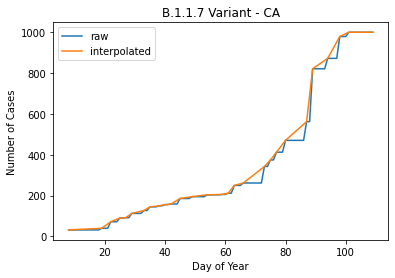

In [ ]:
state = 'CA'

x1, y1 = variants_per_state[state]['Day of Year'], variants_per_state[state][variants[0]]
x2, y2 = variants_per_state[state]['Day of Year'], variants_per_state[state]['Interpolated'][variants[0]]
plt.plot(x1, y1, label='raw')
plt.plot(x2, y2, label='interpolated')
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Number of Cases')
plt.title('{} - {}'.format(variants[0], state))
plt.show()

In [ ]:
vaccination_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')

temp = [datetime.strptime(d, "%Y-%m-%d") for d in vaccination_df['date'].to_list()]
temp = [date(d.year, d.month, d.day) for d in temp]
raw_days = [(d - date(d.year, 1, 1)).days + 1 for d in temp]

vaccination_df['day'] = raw_days

for col in vaccination_df.columns:
    vaccination_df[col] = vaccination_df[col].fillna(-1)

vaccination_df

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,day
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,-1.0,-1.0,-1.0,0.207,12
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,13
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,-1.00,1.88,-1.0,1.64,8.88,8260.0,7083.0,1445.0,0.212,14
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,15
4,2021-01-16,Alabama,-1.0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.00,-1.00,7557.0,7498.0,1529.0,-1.000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,2021-04-27,Wyoming,348695.0,476385.0,194585.0,26.87,60.25,155503.0,33.62,82.31,16.0,2276.0,3933.0,0.732,117
7169,2021-04-28,Wyoming,348883.0,477985.0,194680.0,26.90,60.28,155665.0,33.64,82.59,188.0,2279.0,3938.0,0.730,118
7170,2021-04-29,Wyoming,353401.0,478185.0,195885.0,27.42,61.06,158672.0,33.85,82.62,4518.0,2263.0,3910.0,0.739,119
7171,2021-04-30,Wyoming,356057.0,479485.0,196453.0,27.76,61.52,160656.0,33.94,82.85,2656.0,2182.0,3770.0,0.743,120


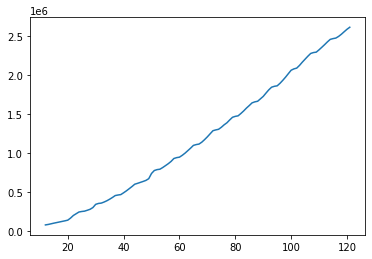

In [ ]:
vaccination_states = names

vaccination_states_map = dict((state, i) for i, state in enumerate(vaccination_states))
quantitative_columns = list(vaccination_df.columns)
quantitative_columns.remove('date')
quantitative_columns.remove('day')
quantitative_columns.remove('location')

df_per_state = {}
for state in vaccination_states:
    df_per_state[state] = vaccination_df[vaccination_df['location'] == state]
    df_per_state[state] = df_per_state[state].reset_index(drop=True)

vaccinations_per_state = {}
for state in vaccination_states:
    dct = {}
    for col in df_per_state[state].columns:
        dct[col] = df_per_state[state][col].to_list()
    for col in quantitative_columns:
        body = []
        idxs = []
        for i, e in enumerate(dct[col]):
            if e != -1:
                idxs.append(i)
        y = [dct[col][i] for i in idxs]
        f = interp1d(idxs, y, kind='slinear')
        body = f(list(range(idxs[0], idxs[-1]+1)))

        prefix = [dct[col][idxs[0]] for i in range(0, idxs[0])]
        suffix = [dct[col][idxs[-1]] for i in range(idxs[-1]+1, len(dct[col]))]
        dct[col] = np.concatenate((prefix, body, suffix))
    vaccinations_per_state[state] = dct

days = vaccinations_per_state['Alabama']['day']
vaccinated = vaccinations_per_state['Alabama']['total_vaccinations']

plt.plot(days, vaccinated)

# Constructing Time Series

In [ ]:
# days from both datasets intersect from 1/12 to 4/19
# removing last two weeks because much of the data there is just propagated from an earlier date

start = (date(2021, 1, 12) - date(2021, 1, 1)).days + 1
end = (date(2021, 4, 5) - date(2021, 1, 1)).days + 1

# need today and 9 days before to estimate variant distribution
p = 9

# 21 time steps per point
n = 21

# 7 days for prediction
t = 7

# predicting 14 day ahead
d = 14

codes_map = dict((code, i) for i, code in enumerate(codes))

X, Y_B117, Y_B1351, Y_P1 = [], [], [], []
testX, testY_B117, testY_B1351, testY_P1 = [], [], [], []

empty = [0 for _ in codes]

for code in codes:
    state = empty.copy()
    state[codes_map[code]] = 1

    name = to_names[code]

    idx = 0
    while vaccinations_per_state[name]['day'][idx] != start + p:
        idx += 1

    metric = 'people_fully_vaccinated_per_hundred'
    vacc = [vaccinations_per_state[name][metric][idx+i] for i in range(end-start-d-p+1)]
    
    idx = 0
    while variants_per_state[code]['Day of Year'][idx] != start + p:
        idx += 1

    b117 = [sum([variants_per_state[code]['Interpolated']['B.1.1.7 Variant'][idx-i] for i in range(p+1)])]
    b1351 = [sum([variants_per_state[code]['Interpolated']['B.1.351 Variant'][idx-i] for i in range(p+1)])]
    p1 = [sum([variants_per_state[code]['Interpolated']['P.1 Variant'][idx-i] for i in range(p+1)])]

    for i in range(1, end-start-p+1):
        rm = variants_per_state[code]['Interpolated']['B.1.1.7 Variant'][idx+i-p-1]
        add = variants_per_state[code]['Interpolated']['B.1.1.7 Variant'][idx+i]
        b117.append(b117[-1] - rm + add)

        rm = variants_per_state[code]['Interpolated']['B.1.351 Variant'][idx+i-p-1]
        add = variants_per_state[code]['Interpolated']['B.1.351 Variant'][idx+i]
        b1351.append(b1351[-1] - rm + add)

        rm = variants_per_state[code]['Interpolated']['P.1 Variant'][idx+i-p-1]
        add = variants_per_state[code]['Interpolated']['P.1 Variant'][idx+i]
        p1.append(p1[-1] - rm + add)

    for i in range(len(b117)):
        tot = b117[i] + b1351[i] + p1[i]
        b117[i] /= tot
        b1351[i] /= tot
        p1[i] /= tot

    for i in range(end-start-p-d-t-n+2):
        tempX = []
        for j in range(n):
            tempX.append(state + [b117[i+j], b1351[i+j], p1[i+j], vacc[i+j]])
            #tempX.append([b117[i+j], b1351[i+j], p1[i+j], vacc[i+j]])
        X.append(tempX)
        Y_B117.append(b117[i+n+d-1])
        Y_B1351.append(b1351[i+n+d-1])
        Y_P1.append(p1[i+n+d-1])

    for i in range(end-start-p-d-t-n+2, end-start-p-d-n+2):
        temp_testX = []
        for j in range(n):
            temp_testX.append(state + [b117[i+j], b1351[i+j], p1[i+j], vacc[i+j]])
            #temp_testX.append([b117[i+j], b1351[i+j], p1[i+j], vacc[i+j]])
        testX.append(temp_testX)
        testY_B117.append(b117[i+n+d-1])
        testY_B1351.append(b1351[i+n+d-1])
        testY_P1.append(p1[i+n+d-1])

X, Y_B117, Y_B1351, Y_P1 = np.array(X), np.array(Y_B117), np.array(Y_B1351), np.array(Y_P1)
testX, testY_B117, testY_B1351, testY_P1 = np.array(testX), np.array(testY_B117), np.array(testY_B1351), np.array(testY_P1)

print(np.shape(X), np.shape(Y_B117))
print(np.shape(testX), np.shape(testY_B117))

(1700, 21, 54) (1700,)
(350, 21, 54) (350,)


# LSTM

In [ ]:
# Cross validation
from sklearn.model_selection import KFold
from tensorflow.keras.losses import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM

inputs = np.concatenate((X, testX), axis=0)
targets_b117 = np.concatenate((Y_B117, testY_B117), axis=0)
targets_b1351 = np.concatenate((Y_B1351, testY_B1351), axis=0)
targets_p1 = np.concatenate((Y_P1, testY_P1), axis=0)

kfold = KFold(n_splits=5, shuffle=True)

print('B.1.1.7 Model\n')

fold_no = 1
losses = []
for train, test in kfold.split(inputs, targets_b117):
    b117_model = Sequential()
    b117_model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n, 54)))
    b117_model.add(LSTM(5, activation='relu', input_shape=(n, 54)))
    b117_model.add(Dense(1))
    b117_model.compile(optimizer='adam', loss='mse')
    b117_model.fit(inputs[train], targets_b117[train], epochs=30, verbose=0)

    scores = b117_model.evaluate(inputs[test], targets_b117[test], verbose=0)
    print(f'Score for fold {fold_no}: {b117_model.metrics_names[0]} of {scores}')
    fold_no += 1
    
    losses.append(scores)
print('Avg B.1.1.7 loss: {}\n'.format(np.mean(losses)))

print('B.1.351 Model\n')

fold_no = 1
losses = []
for train, test in kfold.split(inputs, targets_b1351):
    b1351_model = Sequential()
    b1351_model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n, 54)))
    b1351_model.add(LSTM(5, activation='relu', input_shape=(n, 54)))
    b1351_model.add(Dense(1))
    b1351_model.compile(optimizer='adam', loss='mse')
    b1351_model.fit(inputs[train], targets_b1351[train], epochs=30, verbose=0)

    scores = b1351_model.evaluate(inputs[test], targets_b1351[test], verbose=0)
    print(f'Score for fold {fold_no}: {b1351_model.metrics_names[0]} of {scores}')
    fold_no += 1

    losses.append(scores)
print('Avg B.1.351 loss: {}\n'.format(np.mean(losses)))

print('P.1 Model\n')

fold_no = 1
losses = []
for train, test in kfold.split(inputs, targets_p1):
    p1_model = Sequential()
    p1_model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n, 54)))
    p1_model.add(LSTM(5, activation='relu', input_shape=(n, 54)))
    p1_model.add(Dense(1))
    p1_model.compile(optimizer='adam', loss='mse')
    p1_model.fit(inputs[train], targets_p1[train], epochs=30, verbose=0)

    scores = p1_model.evaluate(inputs[test], targets_p1[test], verbose=1)
    print(f'Score for fold {fold_no}: {p1_model.metrics_names[0]} of {scores}')
    fold_no += 1

    losses.append(scores)
print('Avg P.1 loss: {}\n'.format(np.mean(losses)))

B.1.1.7 Model

Score for fold 1: loss of 0.00034188557765446603
Score for fold 2: loss of 0.006842917762696743
Score for fold 3: loss of 0.0011175774270668626
Score for fold 4: loss of 0.0003609799896366894
Score for fold 5: loss of 0.0005809823051095009
Avg B.1.1.7 loss: 0.0018488686124328523

B.1.351 Model

Score for fold 1: loss of 0.0001423588109901175
Score for fold 2: loss of 0.00034274253994226456
Score for fold 3: loss of 0.046567175537347794
Score for fold 4: loss of 0.00022684580471832305
Score for fold 5: loss of 0.00021621301129925996
Avg B.1.351 loss: 0.009499067140859551

P.1 Model

13/13 [==============================] - 0s 3ms/step - loss: 1.6212e-04
Score for fold 1: loss of 0.00016212293121498078
13/13 [==============================] - 0s 3ms/step - loss: 8.7173e-05
Score for fold 2: loss of 8.717253513168544e-05
13/13 [==============================] - 0s 4ms/step - loss: 2.4773e-04
Score for fold 3: loss of 0.0002477266825735569
13/13 [============================

In [ ]:
# model training

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM

b117_model = Sequential()
b117_model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n, 54)))
b117_model.add(LSTM(5, activation='relu', input_shape=(n, 54)))
b117_model.add(Dense(1))
b117_model.compile(optimizer='adam', loss='mse')
b117_model.fit(X, Y_B117, epochs=30, validation_split=0.1, verbose=1)

b1351_model = Sequential()
b1351_model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n, 54)))
b1351_model.add(LSTM(5, activation='relu', input_shape=(n, 54)))
b1351_model.add(Dense(1))
b1351_model.compile(optimizer='adam', loss='mse')
b1351_model.fit(X, Y_B1351, epochs=30, validation_split=0.1, verbose=1)

p1_model = Sequential()
p1_model.add(LSTM(5, activation='relu', return_sequences=True, input_shape=(n, 54)))
p1_model.add(LSTM(5, activation='relu', input_shape=(n, 54)))
p1_model.add(Dense(1))
p1_model.compile(optimizer='adam', loss='mse')
p1_model.fit(X, Y_P1, epochs=30, validation_split=0.1, verbose=1)

b117_model.summary()

Epoch 1/30
48/48 [==============================] - 3s 21ms/step - loss: 1.4461 - val_loss: 0.2996
Epoch 2/30
48/48 [==============================] - 1s 14ms/step - loss: 0.2190 - val_loss: 0.0766
Epoch 3/30
48/48 [==============================] - 1s 15ms/step - loss: 0.0603 - val_loss: 0.0353
Epoch 4/30
48/48 [==============================] - 1s 14ms/step - loss: 0.0301 - val_loss: 0.0252
Epoch 5/30
48/48 [==============================] - 1s 16ms/step - loss: 0.0196 - val_loss: 0.0209
Epoch 6/30
48/48 [==============================] - 1s 14ms/step - loss: 0.0158 - val_loss: 0.0181
Epoch 7/30
48/48 [==============================] - 1s 14ms/step - loss: 0.0117 - val_loss: 0.0176
Epoch 8/30
48/48 [==============================] - 1s 14ms/step - loss: 0.0093 - val_loss: 0.0186
Epoch 9/30
48/48 [==============================] - 1s 15ms/step - loss: 0.0062 - val_loss: 0.0187
Epoch 10/30
48/48 [==============================] - 1s 18ms/step - loss: 0.0063 - val_loss: 0.0199
Epoch 11/

In [189]:
# number of points per state in training set

factor = int(len(X) / len(names))

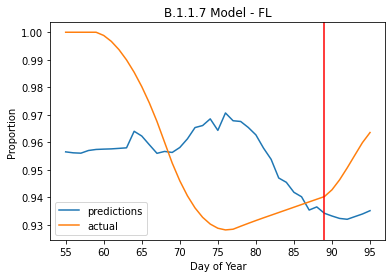

In [190]:
state = 'FL'

idx = codes_map[state]

train_idx = np.array(range((idx-1) * factor, idx * factor))
test_idx = np.array(range((idx-1) * t, idx * t))

i1, i2 = X[train_idx, :], testX[test_idx, :]

input = np.concatenate((i1, i2))

predictions = b117_model.predict(input)
actual = [Y_B117[i] for i in train_idx] + [testY_B117[i] for i in test_idx]

x = list(range(end-len(actual)+1, end+1))

plt.plot(x, predictions, label='predictions')
plt.plot(x, actual, label='actual')
plt.axvline(x=end-t+1, color='r')
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Day of Year')
plt.title('B.1.1.7 Model - {}'.format(state))
plt.show()

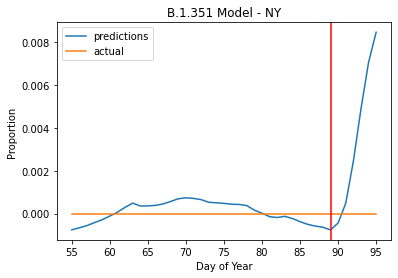

In [191]:
state = 'NY'

idx = codes_map[state]

train_idx = np.array(range((idx-1) * factor, idx * factor))
test_idx = np.array(range((idx-1) * t, idx * t))

i1, i2 = X[train_idx, :], testX[test_idx, :]

input = np.concatenate((i1, i2))

predictions = b1351_model.predict(input)
actual = [Y_B1351[i] for i in train_idx] + [testY_B1351[i] for i in test_idx]

x = list(range(end-len(actual)+1, end+1))

plt.plot(x, predictions, label='predictions')
plt.plot(x, actual, label='actual')
plt.axvline(x=end-t+1, color='r')
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Day of Year')
plt.title('B.1.351 Model - {}'.format(state))
plt.show()

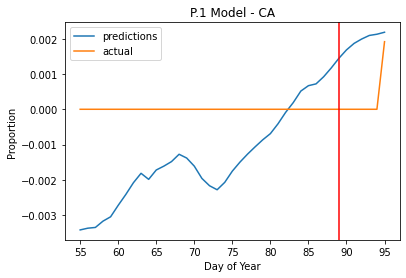

In [192]:
state = 'CA'

idx = codes_map[state]

train_idx = np.array(range((idx-1) * factor, idx * factor))
test_idx = np.array(range((idx-1) * t, idx * t))

i1, i2 = X[train_idx, :], testX[test_idx, :]

input = np.concatenate((i1, i2))

predictions = p1_model.predict(input)
actual = [Y_P1[i] for i in train_idx] + [testY_P1[i] for i in test_idx]

x = list(range(end-len(actual)+1, end+1))

plt.plot(x, predictions, label='predictions')
plt.plot(x, actual, label='actual')
plt.axvline(x=end-t+1, color='r')
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Day of Year')
plt.title('P.1 Model - {}'.format(state))
plt.show()

In [193]:
# testing accuracy outside of training regime

evalX = None
evalY_B117, evalY_B1351, evalY_P1 = [], [], []
for code in codes:
    i = np.array(range((codes_map[state]-1) * t, codes_map[state] * t))
    test_idx = np.array(range((idx-1) * t, idx * t))
    if evalX is None:
        evalX = X[i, :]
    else:
        evalX = np.append(evalX, X[i, :], axis=0)
    evalY_B117 += [testY_B117[j] for j in i]
    evalY_B1351 += [testY_B1351[j] for j in i]
    evalY_P1 += [testY_P1[j] for j in i]
evalY_B117 = np.array(evalY_B117)
evalY_B1351 = np.array(evalY_B1351)
evalY_P1 = np.array(evalY_P1)

print(np.shape(evalX))
print(len(testY_B117))

b117_predictions = b117_model.predict(evalX)
score_b117 = np.mean([(p - evalY_B117[i]) ** 2 for i, p in enumerate(b117_predictions)])

b1351_predictions = b1351_model.predict(evalX)
score_b1351 = np.mean([(p - evalY_B1351[i]) ** 2 for i, p in enumerate(b1351_predictions)])

p1_predictions = p1_model.predict(evalX)
score_p1 = np.mean([(p - evalY_P1[i]) ** 2 for i, p in enumerate(p1_predictions)])

print(score_b117, score_b117 ** 0.5)
print(score_b1351, score_b1351 ** 0.5)
print(score_p1, score_p1 ** 0.5)

scores = b117_model.evaluate(evalX, evalY_B117, verbose=1)
scores = b1351_model.evaluate(evalX, evalY_B1351, verbose=1)
scores = p1_model.evaluate(evalX, evalY_P1, verbose=1)

(350, 21, 54)
350
0.26448512 0.5142811689857169
1.9909136e-07 0.0004461965489408557
0.2986726 0.5465094570814476
11/11 [==============================] - 0s 4ms/step - loss: 0.2987


In [194]:
!pip install tabulate
from tabulate import tabulate

empty = [0 for _ in codes]

one_hot = []
for code in codes:
    state = empty.copy()
    state[codes_map[code]] = 1
    one_hot.append(state)

low_vacc = []
for state in one_hot:
    point = []
    for i in range(n):
        point.append(state + [0.9, 0.05, 0.05, 10])
    low_vacc.append(point)

b117_avg = np.mean(b117_model.predict(low_vacc))
b1351_avg = np.mean(b1351_model.predict(low_vacc))
p1_avg = np.mean(p1_model.predict(low_vacc))

result_low = np.array([b117_avg, b1351_avg, p1_avg])
result_low = list(result_low / sum(result_low))

med_vacc = []
for state in one_hot:
    point = []
    for i in range(n):
        point.append(state + [0.9, 0.05, 0.05, 30])
    med_vacc.append(point)

b117_avg = np.mean(b117_model.predict(med_vacc))
b1351_avg = np.mean(b1351_model.predict(med_vacc))
p1_avg = np.mean(p1_model.predict(med_vacc))

result_med = np.array([b117_avg, b1351_avg, p1_avg])
result_med = list(result_med / sum(result_med))

high_vacc = []
for state in one_hot:
    point = []
    for i in range(n):
        point.append(state + [0.9, 0.05, 0.05, 50])
    high_vacc.append(point)

b117_avg = np.mean(b117_model.predict(high_vacc))
b1351_avg = np.mean(b1351_model.predict(high_vacc))
p1_avg = np.mean(p1_model.predict(high_vacc))

result_high = np.array([b117_avg, b1351_avg, p1_avg])
result_high = list(result_high / sum(result_high))

table = [['#', 'B.1.1.7', 'B.1.351', 'P.1'], ['Low Vaccination'] + result_low, ['Medium Vaccination'] + result_med, ['High Vaccination'] + result_high]
# print(tabulate(table))

data = {'#' : ['B.1.1.7', 'B.1.351', 'P.1'], 'Low Vaccination' : result_low, 'Medium Vaccination' : result_med, 'High Vaccination' : result_high}
df = pd.DataFrame(data=data)
df

,#,Low Vaccination,Medium Vaccination,High Vaccination
0,B.1.1.7,0.939490,0.988479,1.024749
1,B.1.351,0.034516,0.021579,0.006795
2,P.1,0.025993,-0.010058,-0.031545
